In [24]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import scipy.signal as signal
from math import log10
import biosignalsnotebooks as bsnb

# Scientific packages
from numpy import linspace, max, min, average, std, array, diff, fabs, sqrt, power, round
from scipy.integrate import simps

**SE OBTIENE EL DATASET**




In [25]:
fs = 1000
ecg = np.genfromtxt("ECG_1_2.txt", delimiter="\t",skip_header = 3)[:,-2]
print(ecg)

[470. 467. 472. ... 473. 476. 478.]


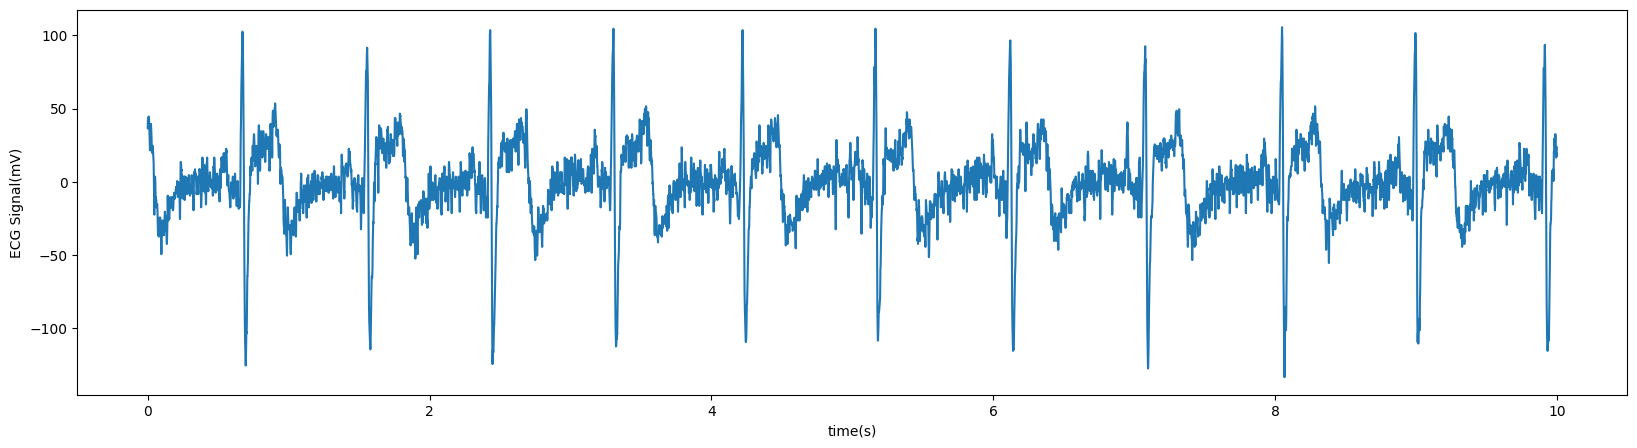

In [29]:
# A numpy

ecg_sig = ecg[20000:30000]
ecg_sig = ecg_sig - np.mean(ecg_sig)
t = np.arange(0, len(ecg_sig))/fs
plt.figure(figsize=(20,5))
plt.plot(t, ecg_sig)
plt.ylabel('ECG Signal(mV)')
plt.xlabel('time(s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

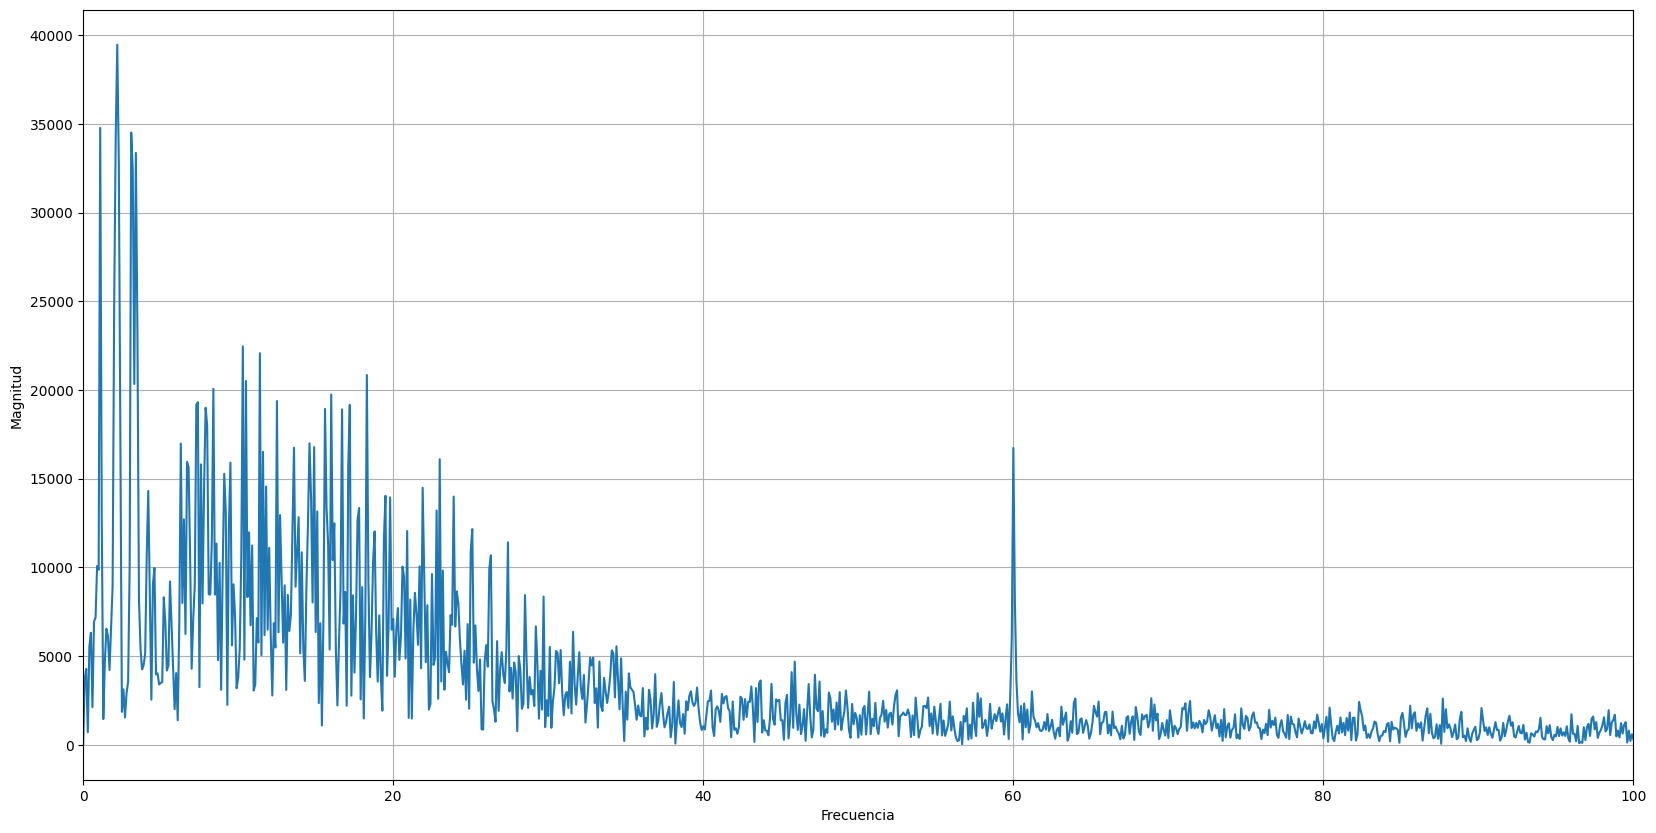

In [31]:
# Analizar el Fourier
N = len(ecg_sig)
SAMP1 = np.fft.fft(ecg_sig)
SAMP1 = SAMP1 [0:N//2]
f1= np.linspace(0,fs/2,N//2)

plt.figure(figsize=(20,10))
plt.plot(f1, np.abs(SAMP1))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud");plt.xlim([0,100])
plt.show()

En el gráfico anterior, existe un ruido en 50 Hz y armónicos en 150 HZ. Por lo tanto, se debe filtrar.

Se propone utilizar filtros digitales Notch



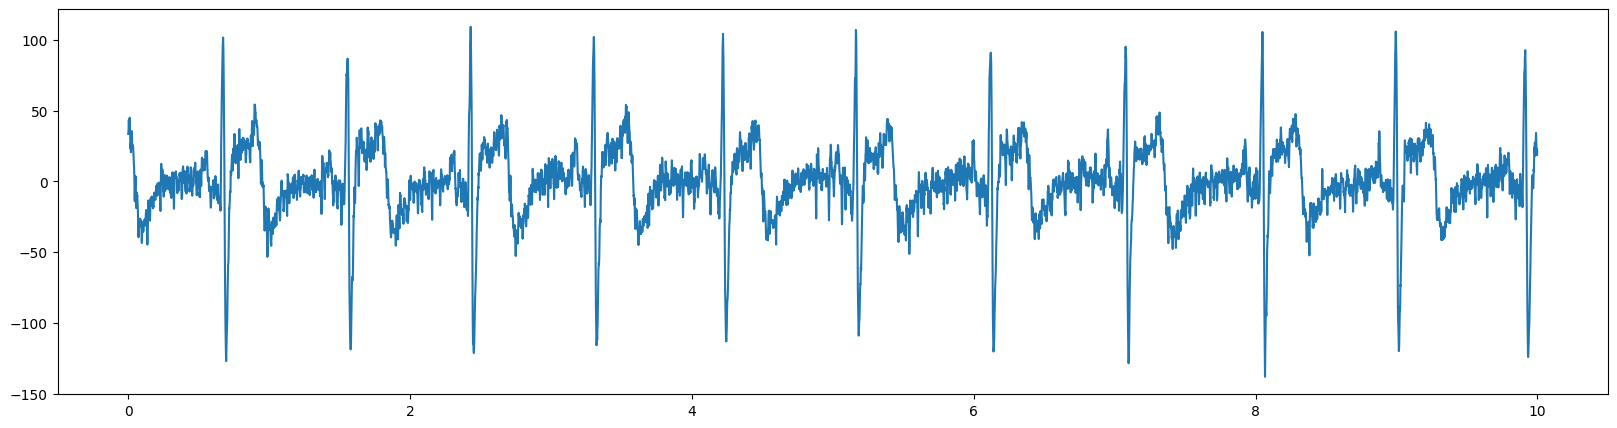

1000.0


In [36]:
# Utilizar filtros Notch para quitar frecuencias que hagan ruido
from scipy.signal import iirnotch, lfilter
f0 = 60.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, ecg_sig)
y = lfilter(b, a, y)
f0 = 150.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)
plt.figure(figsize=(20,5))
#plt.xlim(0,200)
plt.plot(t,y)
plt.show()
print(fs)

Regresamos a verificar las atenuaciones de los filtros en frecuencia

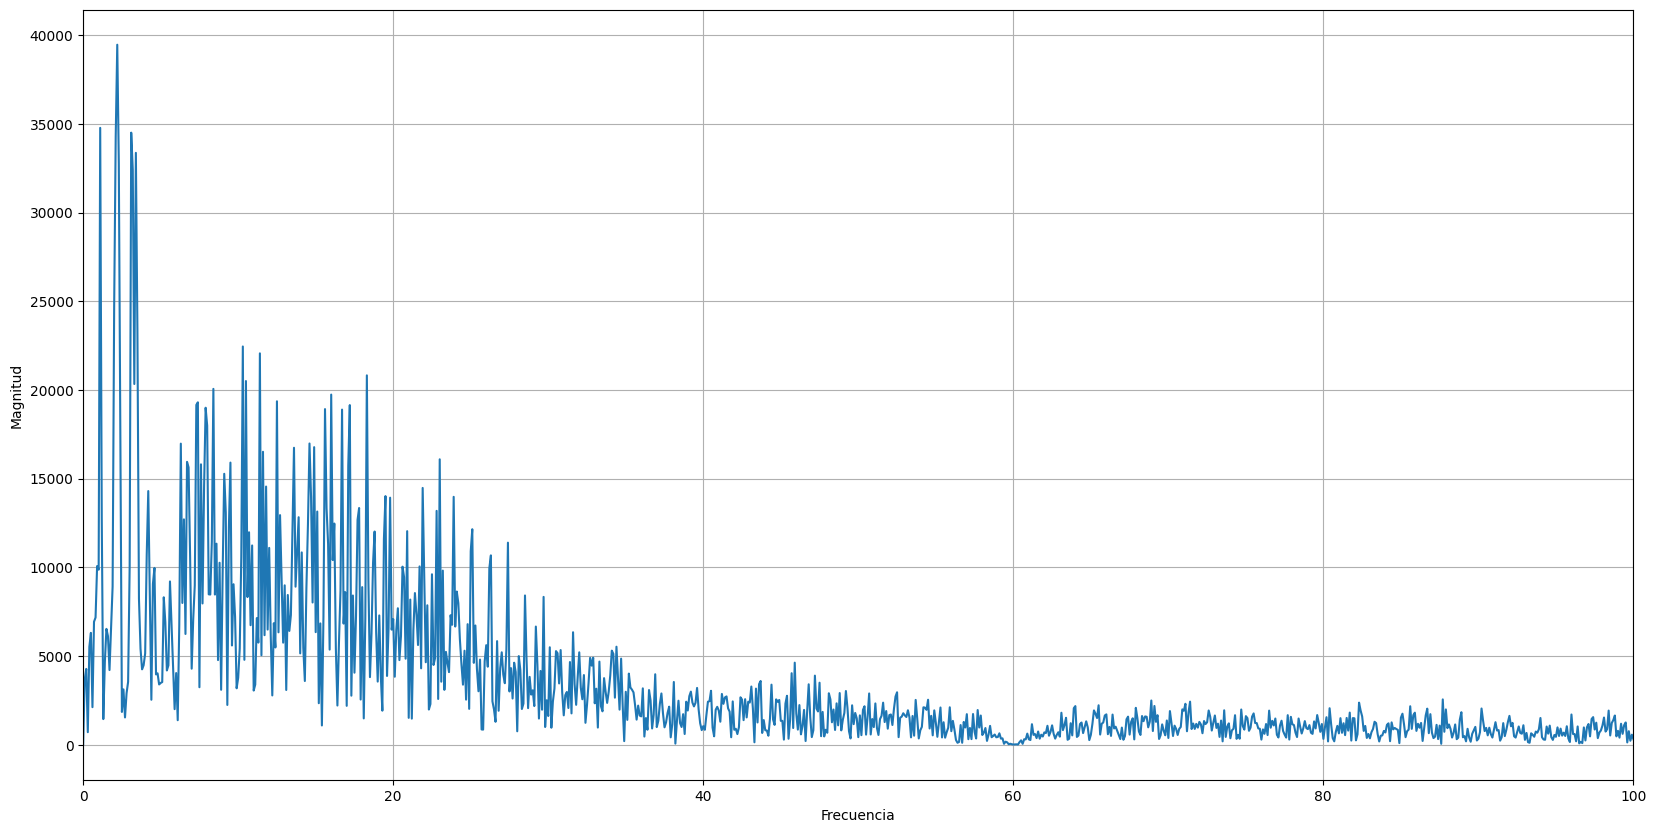

In [37]:
# Analisis de Fourier de los filtros
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
# Analizar el Fourier
N = len(y)
SAMP1 = np.fft.fft(y)

SAMP1 = SAMP1 [0:N//2]
f1= np.linspace(0,fs/2,N//2)
ecg_sig = y
plt.figure(figsize=(20,10))
plt.plot(f1, np.abs(SAMP1))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud");plt.xlim([0,100])
plt.show()

**FILTRADO DE PASA BANDA**

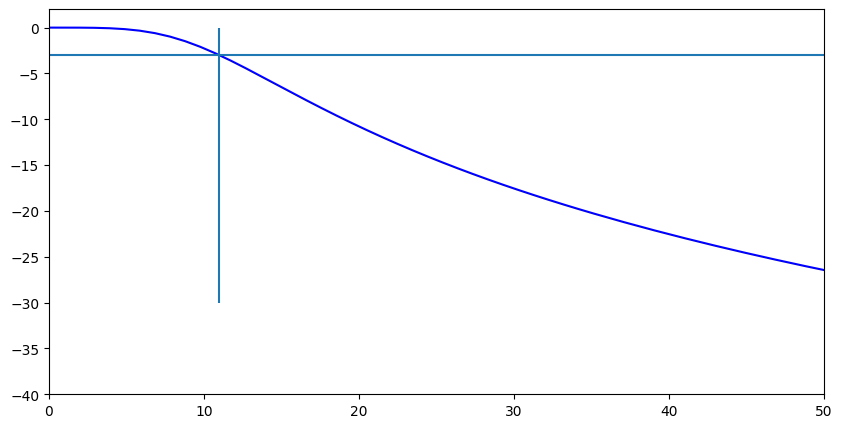

In [38]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=fs)
w, h = freqz(b, a, fs=fs)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

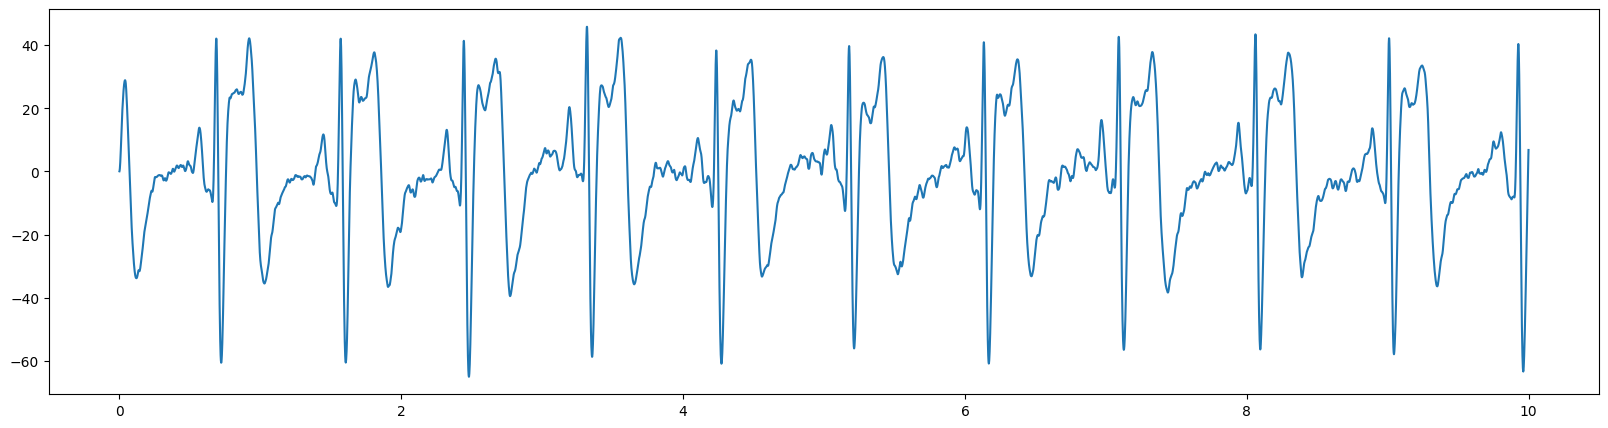

In [39]:
fpb_signal = lfilter(b, a, ecg_sig)
plt.figure(figsize=(20,5))
plt.plot(t,fpb_signal)
plt.show()

**FILTRO PASA ALTO**

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_5740\2808401124.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


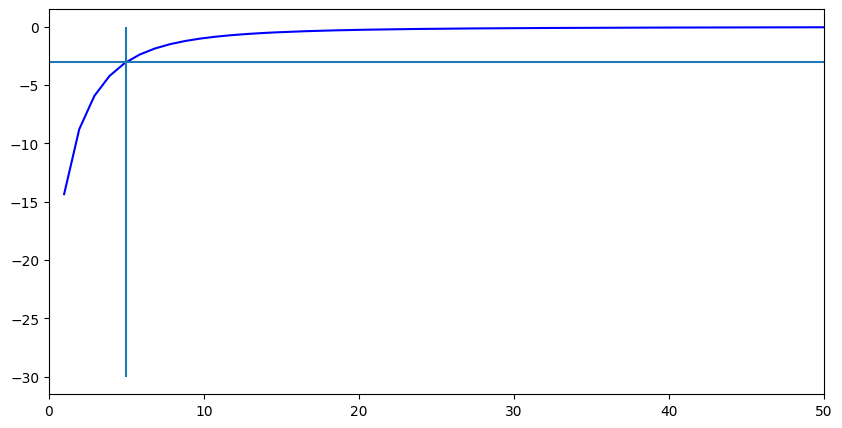

In [40]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=fs)
w, h = freqz(b, a, fs=fs)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


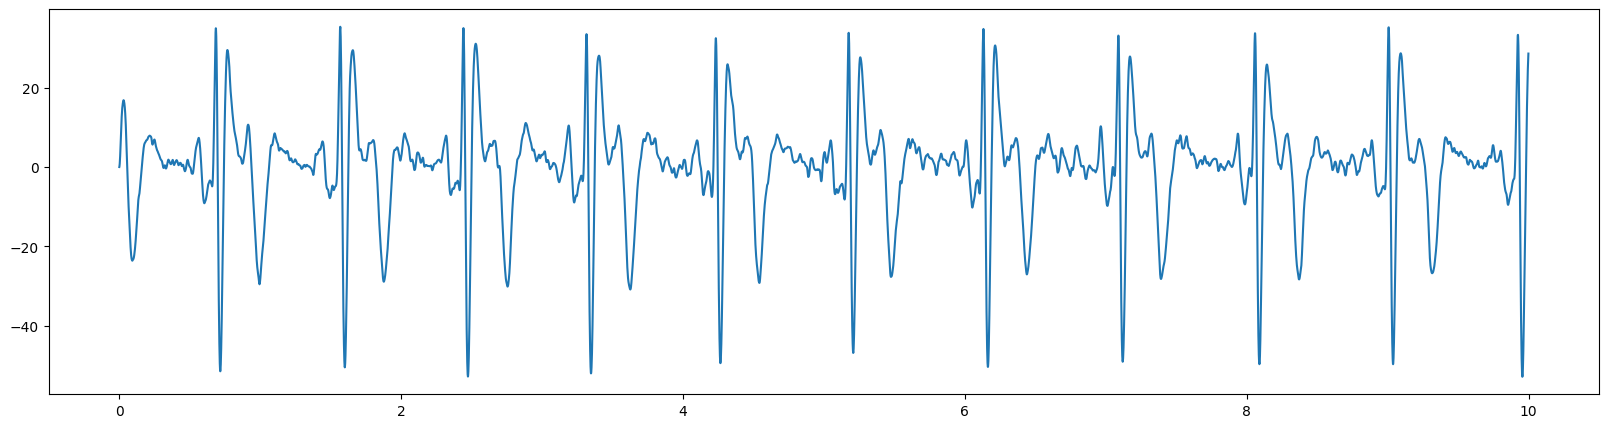

In [41]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fpa_signal)
plt.show()

**OPERADOR DERIVATIVO**

En el artículo nos dan la siguiente función que describe al operador:

y[n]=(1/8)(−x[n−2]−2x[n−1]+2x[n+1]+x[n+2])

Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de  [0,+∞]  haciendo que  n=+2  entonces tenemos:

y[n]=(1/8)(−x[n]−2x[n+1]+2x[n+3]+x[n+4]) 

Por lo tanto:

b=[−1,−2,0,2,1]

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_5740\1745459298.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


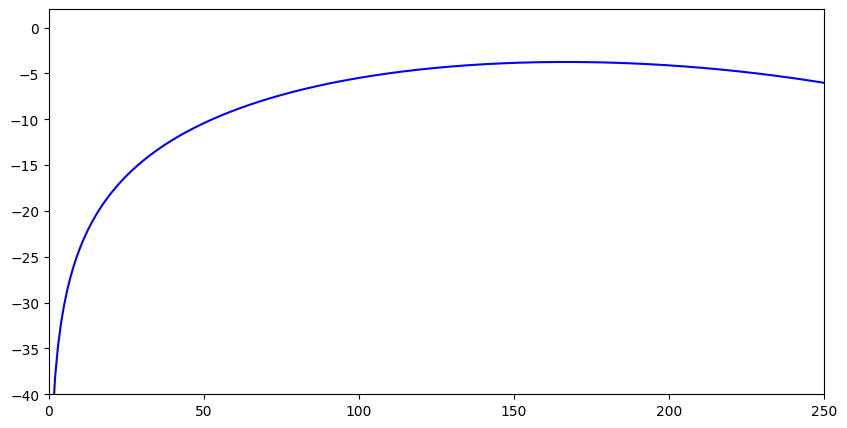

In [49]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=fs)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

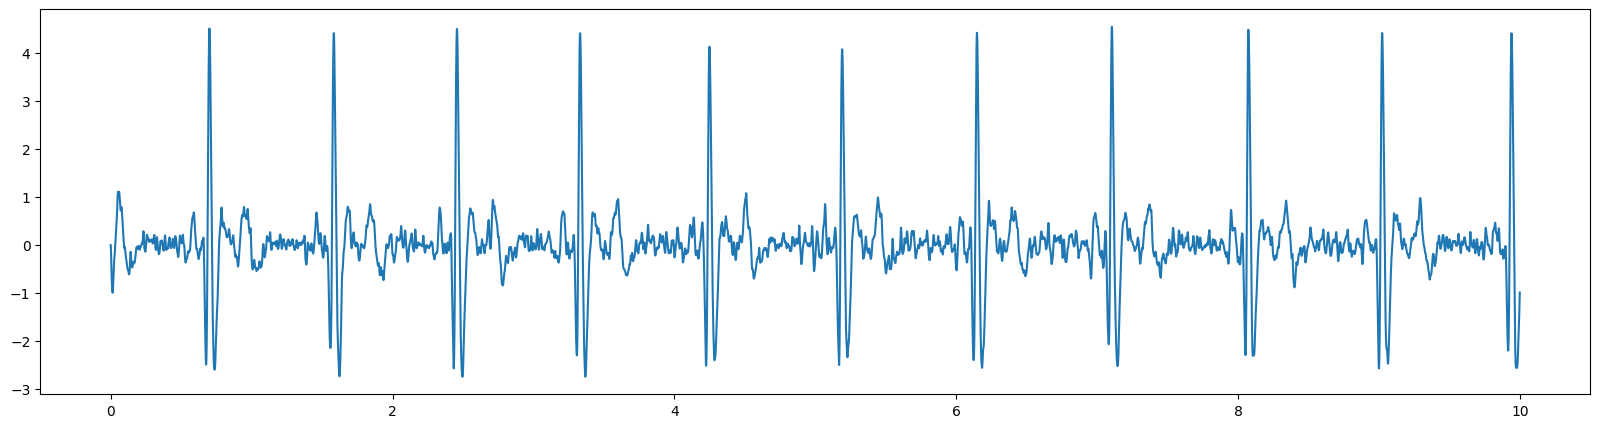

In [50]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fd_signal)
plt.show()

**OPERADOR CUADRÁTICO**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

y[n]=x^2[n]

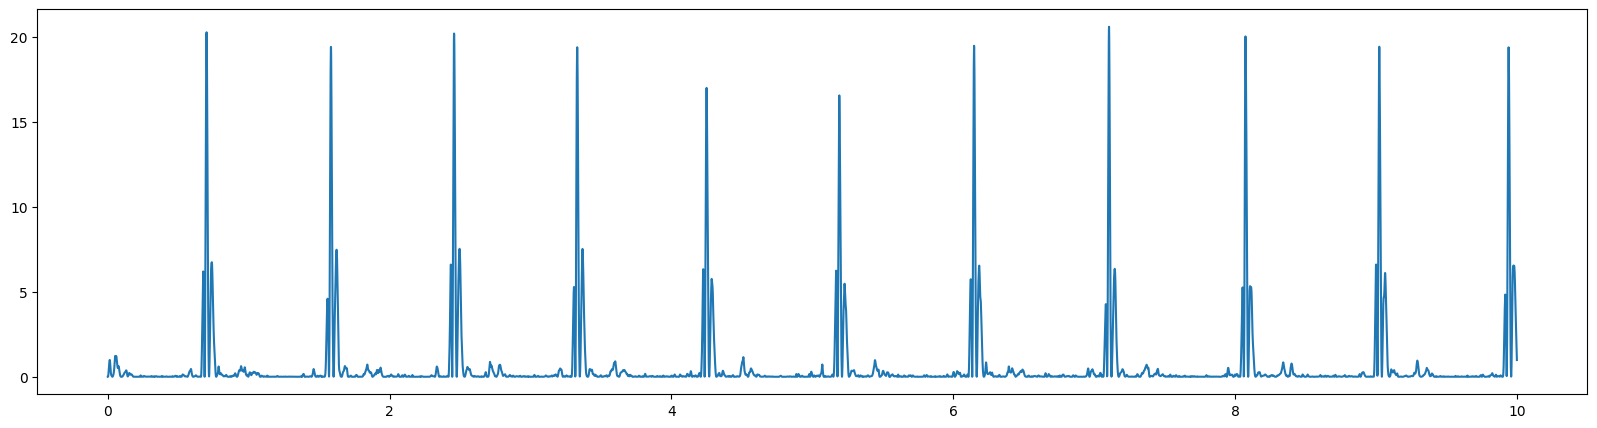

In [52]:
# Filtro cuadrado
f_sq = np.square(fd_signal)
plt.figure(figsize=(20,5))
plt.plot(t, f_sq)
plt.show()

**OPERADOR MOVING WINDOW INTEGRATION**

Este operador tiene como función extraer ciertas características de la onda.

y[n]=(1/N)(x[n−(N−1)]+x[n−(N−2)]+..+x[n])

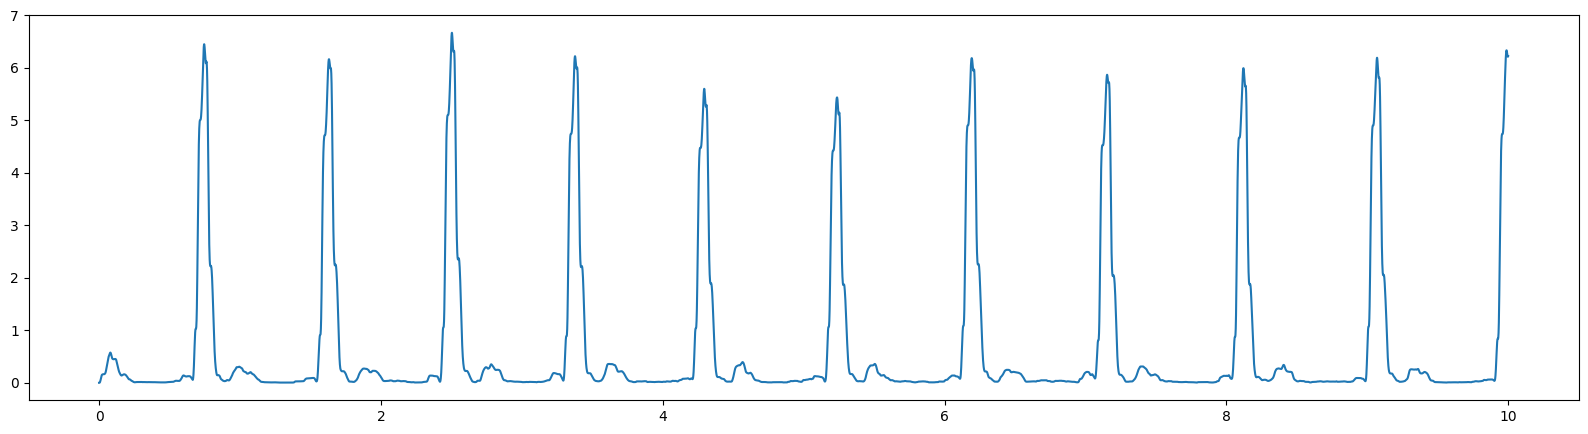

In [53]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(t,fi_signal)
plt.show()

Colocando marcadores en los picos

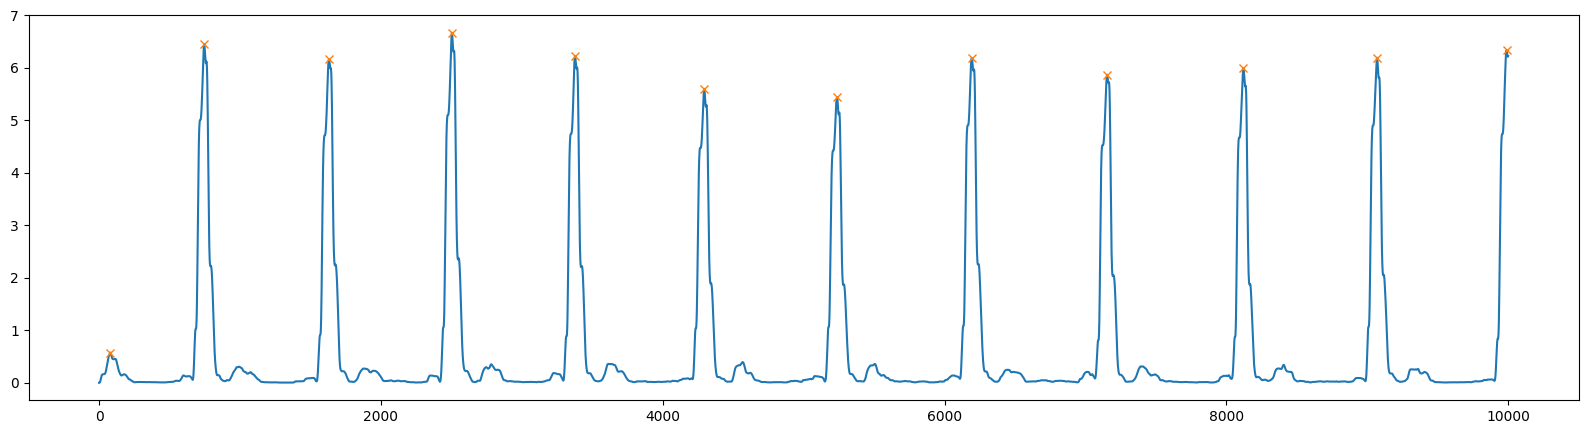

In [56]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=600)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

**ANÁLISIS DE THRESHOLD**

El valor del umbral de pico R de entrada es  1.6672675733846245
El valor del umbral de ruido de entrada es  2.8205928928943833


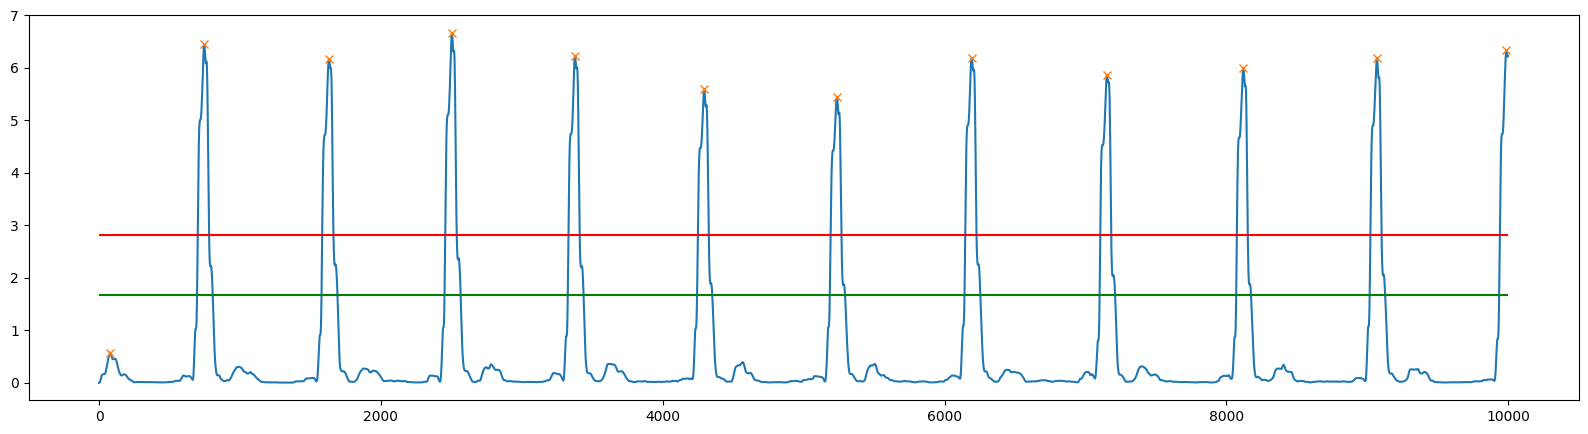

In [57]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.25
th_I2 = 0.5*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

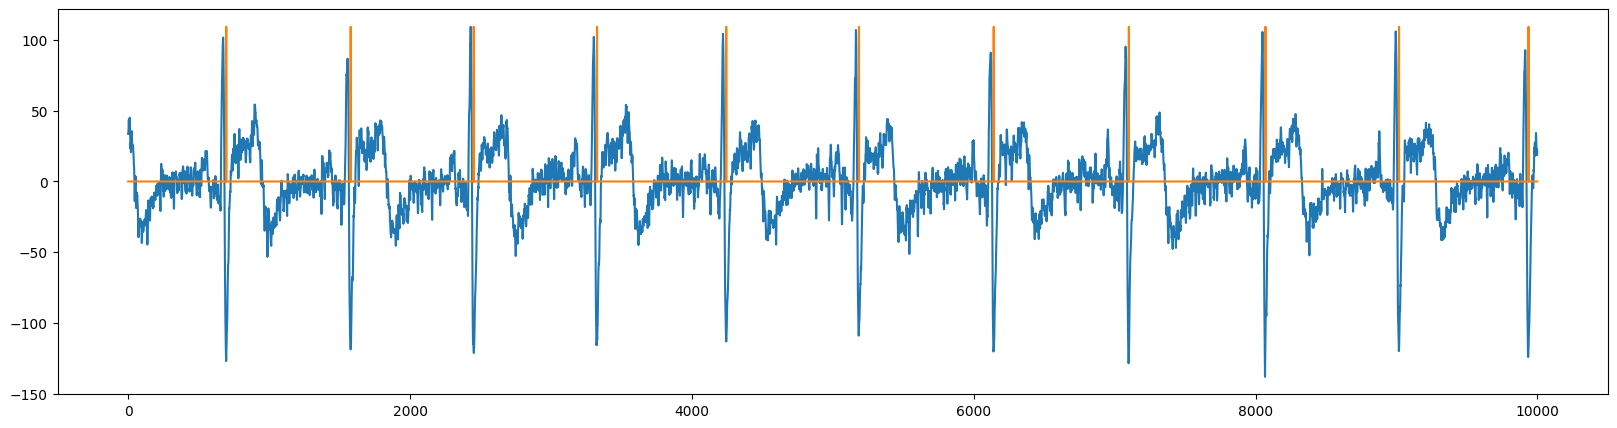

In [59]:
end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.plot(ecg_sig)
plt.plot(end_qrs*np.max(ecg_sig))
plt.show()

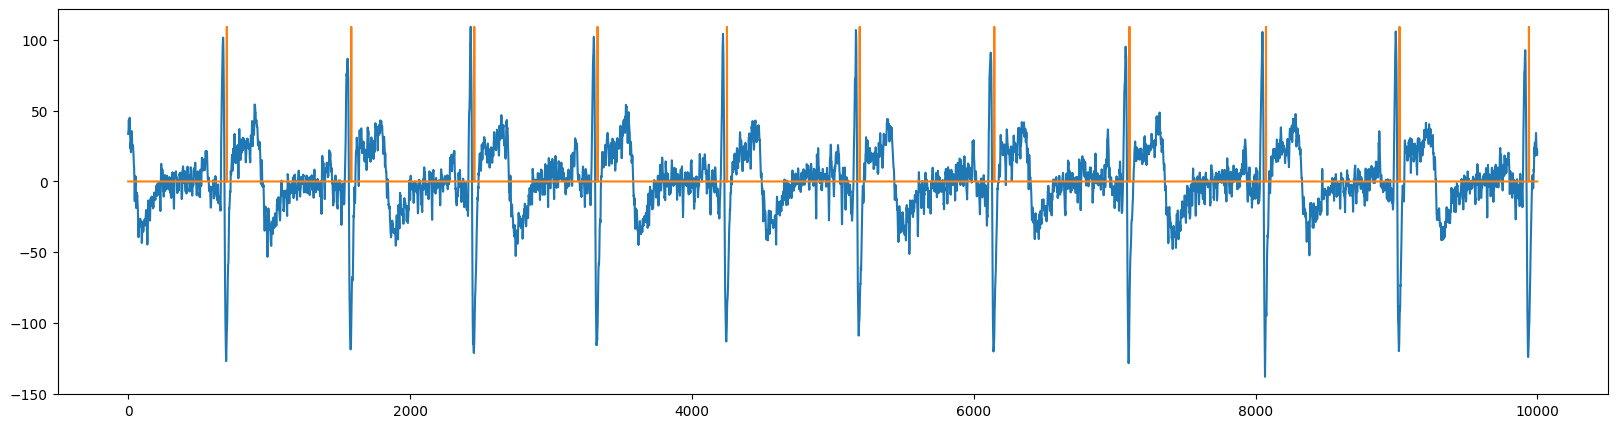

In [60]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_sig)
plt.plot(start_qrs*np.max(ecg_sig))
plt.show()

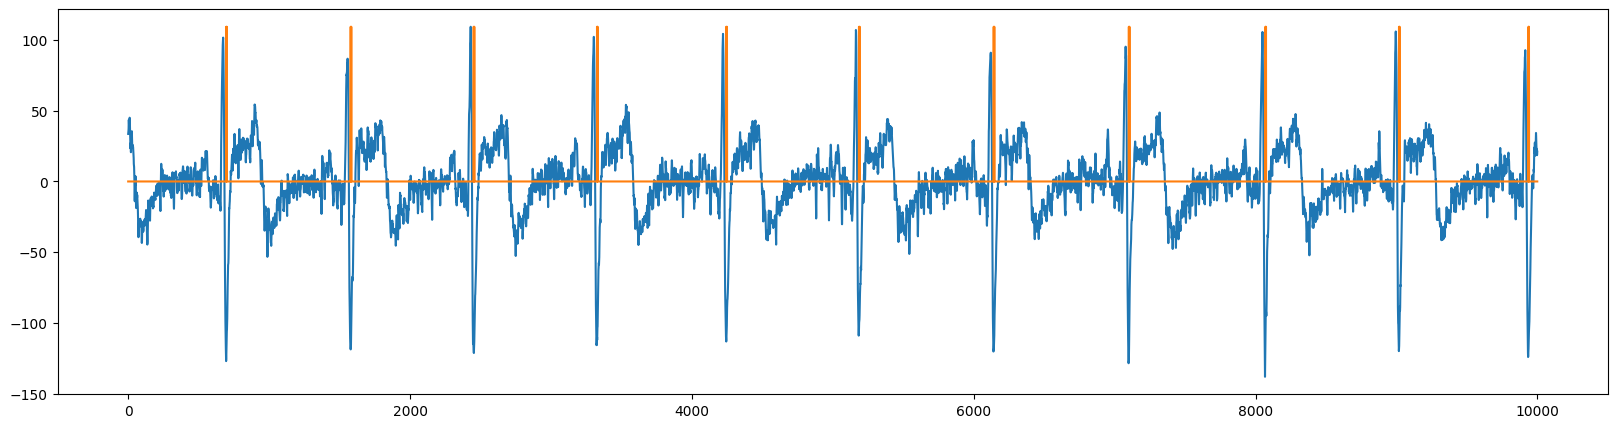

In [62]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_sig)
plt.plot(qrs*np.max(ecg_sig))
plt.show()


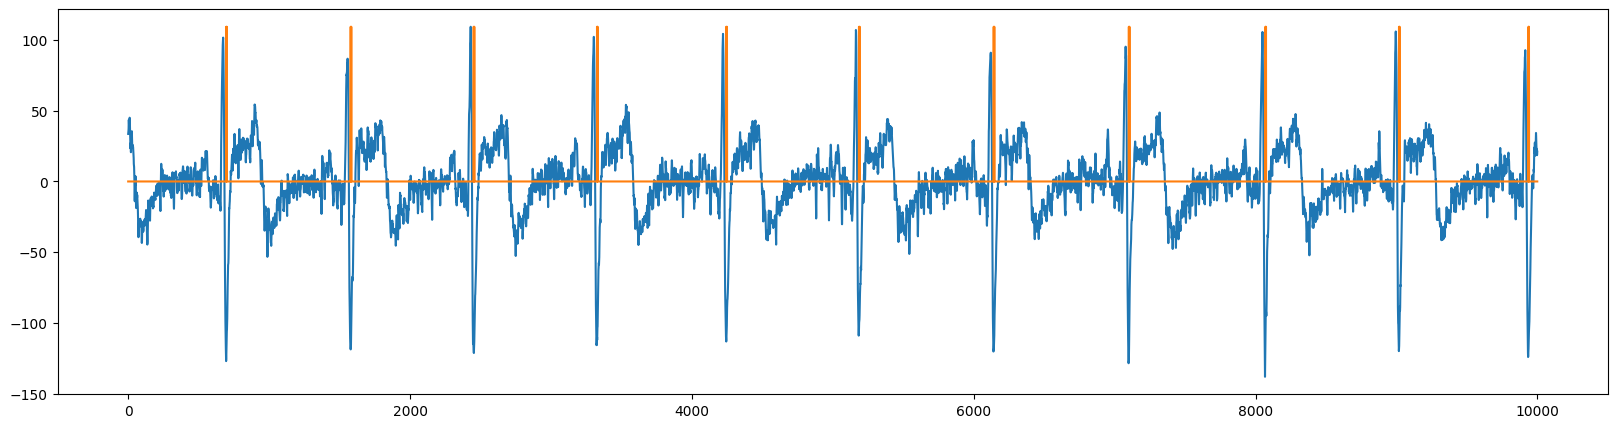

In [63]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_sig)
plt.plot(qrs*np.max(ecg_sig))
plt.show()

In [75]:

tachogram_data, tachogram_time = bsnb.tachogram(fpa_signal, int(fs), signal=True, out_seconds=True)
tachogram_data_NN, tachogram_time_NN = bsnb.remove_ectopy(tachogram_data, tachogram_time)
bpm_data = (1 / array(tachogram_data_NN)) * 60

In [87]:
# Maximum, Minimum and Average RR Interval
max_rr = max(tachogram_data_NN)
min_rr = min(tachogram_data_NN)
avg_rr = average(tachogram_data_NN)

# Maximum, Minimum and Average Heart Rate
max_hr = 1 / min_rr # Cycles per second
max_bpm = max_hr * 60 # BPM

min_hr = 1 / max_rr # Cycles per second
min_bpm = min_hr * 60 # BPM

avg_hr = 1 / avg_rr # Cyles per second
avg_bpm = avg_hr * 60 # BPM

# SDNN
sdnn = float(std(tachogram_data_NN))

time_param_dict = {"Maximum RR": max_rr, "Minimum RR": min_rr, "Average RR": avg_rr, "Maximum BPM": max_bpm, "Minimum BPM": min_bpm, "Average BPM": avg_bpm, "SDNN": sdnn}
print(time_param_dict)

{'Maximum RR': 0.9700970097009698, 'Minimum RR': 0.8730873087308733, 'Average RR': 0.9247591425809247, 'Maximum BPM': 68.72164948453606, 'Minimum BPM': 61.8494845360825, 'Average BPM': 64.8817591925018, 'SDNN': 0.036390449842304586}


In [104]:
# Auxiliary Structures
tachogram_diff = diff(tachogram_data)
tachogram_diff_abs = fabs(tachogram_diff)
sdsd = float(std(tachogram_diff))
rr_i = tachogram_data[:-1]
rr_i_plus_1 = tachogram_data[1:]

# PoincarÃ© Parameters
sd1 = np.sqrt(0.5 * np.power(sdsd, 2))
sd2 = np.sqrt(2 * np.power(sdnn, 2) - np.power(float(sd1), 2))
sd1_sd2 = sd1 / sd2
# Number of RR intervals that have a difference in duration, from the previous one, of at least 20 ms
nn20 = sum(1 for i in tachogram_diff_abs if i > 0.02)
pnn20 = int(float(nn20) / len(tachogram_diff_abs) * 100) # Percentage value.

# Number of RR intervals that have a difference in duration, from the previous one, of at least 50 ms
nn50 = sum(1 for i in tachogram_diff_abs if i > 0.05)
pnn50 = int(float(nn50) / len(tachogram_diff_abs) * 100) # Percentage value.
print(nn20, pnn20, nn50, pnn50)

3 37 0 0
